In [48]:
import numpy as np
import ctypes
import pyautogui

from PIL import Image, ImageDraw
import decimal

from pytesseract import pytesseract
import pandas as pd
from tqdm import tqdm
import time

In [49]:
from screeninfo import get_monitors
get_monitors()

[Monitor(x=0, y=0, width=2560, height=1440, width_mm=598, height_mm=336, name='\\\\.\\DISPLAY1', is_primary=True),
 Monitor(x=-1920, y=7, width=1920, height=1080, width_mm=527, height_mm=296, name='\\\\.\\DISPLAY2', is_primary=False),
 Monitor(x=0, y=-1080, width=1920, height=1080, width_mm=510, height_mm=290, name='\\\\.\\DISPLAY3', is_primary=False),
 Monitor(x=-1920, y=-1073, width=1920, height=1080, width_mm=509, height_mm=286, name='\\\\.\\DISPLAY4', is_primary=False)]

In [50]:
import mss
import mss.tools

img = None
with mss.mss() as sct:
    # Get information of monitor 2
    monitor_number = 2
    mon = sct.monitors[monitor_number]

    # The screen part to capture
    monitor = {
        "top": mon["top"],
        "left": mon["left"],
        "width": mon["width"],
        "height": mon["height"],
        "mon": monitor_number,
    }
    output = "sct-mon{mon}_{top}x{left}_{width}x{height}.png".format(**monitor)

    # Grab the data
    img = np.array(sct.grab(monitor))
    img = Image.fromarray(img)
    # Save to the picture file
    #mss.tools.to_png(sct_img.rgb, sct_img.size, output=output)
    print(output)

sct-mon2_7x-1920_1920x1080.png


In [15]:
user32.GetSystemMetrics(71), user32.GetSystemMetrics(78)

(15, 4480)

In [23]:
user32 = ctypes.windll.user32
screenSize = user32.GetSystemMetrics(0), user32.GetSystemMetrics(1)
centerPoint = tuple(i/2 for i in screenSize)
monitor_width = screenSize[0]
monitor_height = screenSize[1]

In [24]:
def drange(x, y, jump):
    while x < y:
        yield float(x)
        x += decimal.Decimal(jump)
        
def cell_dims(x1, y1, x2, y2):
    return x1, y1, x2 - x1, y2 - y1

def cell_dims_from_list(list_onbj):
    return cell_dims(list_onbj[0], list_onbj[1], list_onbj[2], list_onbj[3])

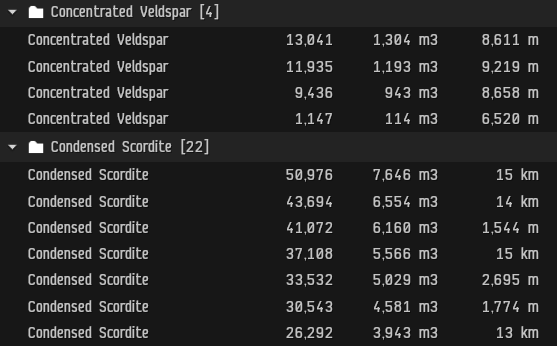

In [54]:
full_screen_image = img
survey_scan_results_box = [1285, 615, 1842, 961] #x,y Top Left ,x,y Bottom Right
full_screen_image.crop(survey_scan_results_box)

In [55]:
def process():
    
    img = None
    with mss.mss() as sct:
        # Get information of monitor 2
        monitor_number = 2
        mon = sct.monitors[monitor_number]

        # The screen part to capture
        monitor = {
            "top": mon["top"],
            "left": mon["left"],
            "width": mon["width"],
            "height": mon["height"],
            "mon": monitor_number,
        }
        output = "sct-mon{mon}_{top}x{left}_{width}x{height}.png".format(**monitor)

    # Grab the data
    img = np.array(sct.grab(monitor))
    img = Image.fromarray(img)
    
    full_screen_image = img
    survey_scan_results_box = [1285, 615, 1842, 961] #x,y Top Left ,x,y Bottom Right
    
    space = (survey_scan_results_box[3] - survey_scan_results_box[1]) / 12
    row_points= list(drange(survey_scan_results_box[1], survey_scan_results_box[3], f'{space}'))
    final_row_points = list(np.rint(np.asarray(row_points)).astype(int))
    
    col_delta = survey_scan_results_box[2] - survey_scan_results_box[0]
    cols_points =  [col_delta * .05, col_delta * .45, col_delta * .15, col_delta * .18]

    temp_list = []

    for i in range(len(cols_points)):
        this_int = survey_scan_results_box[0]
        for j in range(i + 1):
            this_int += cols_points[j]
        temp_list.append(this_int)

    final_col_points = np.array(temp_list)

    final_col_points = list(np.rint(final_col_points).astype(int))
    final_col_points = [survey_scan_results_box[0]] + final_col_points + [survey_scan_results_box[2]]
    
    x_range = final_col_points
    y_range = final_row_points

    cells = {}

    for i, x in enumerate(x_range):
        for j, y in enumerate(y_range):
            try:
                cells[i, j] = tuple([x, y, x + x_range[i+1], y + y_range[j+1]])
            except:
                pass
            
    frames = []
    columns = ['Locked', 'Ore', 'Quantity', 'Volume', 'Distance', 'click_target']
    for i in tqdm(range(12)):
        frame = {}
        for j in range(0, 5):
            cell = cell_dims_from_list(list(cells[j, i]))
            cell_image = full_screen_image.crop(cell)

            transcript = pytesseract.image_to_string(cell_image, lang='eng')

            frame[columns[j]] = transcript.replace('\n','').replace('+','').replace('>','').replace('k m', ' km')
        frame['click_target'] = (cells[1, i][0] + 10, cells[1, i][1] + 10) # offset by 10x10 pixels
        frames.append(frame)
    df = pd.DataFrame(frames, columns=columns)
    df.loc[df['Locked'] != '', 'Locked'] = '><'
    return df

# Models
https://github.com/tesseract-ocr/tessdata_best/blob/main/eng.traineddata  
C:\Program Files\Tesseract-OCR\tessdata

In [ ]:
time.sleep(0.5)

for l in range(100):
    print('checking...')
    df = process()
    snap_df = df[df['Quantity'].str.len()>0][0:2]
    snap_df = snap_df[~snap_df['Locked'].str.contains('><')]
    indicies = snap_df.index
    if len(indicies) == 2:
        print('starting 2x...')
        for i in indicies:
            pyautogui.moveTo(df.loc[i, 'click_target'])
            time.sleep(0.1)
            pyautogui.keyDown('ctrl')
            time.sleep(0.1)
            pyautogui.click()
            time.sleep(0.1)
            pyautogui.keyUp('ctrl')
            time.sleep(0.5)
        time.sleep(3)
        xy=None
        for i, index in enumerate(indicies):
            xy = df.loc[index, 'click_target']
            pyautogui.moveTo(xy)
            time.sleep(0.1)
            pyautogui.click()
            time.sleep(0.1)
            pyautogui.press(f'f{i + 1}')
            time.sleep(0.5)
        xy = (xy[0], xy[1]-200)
        pyautogui.moveTo(xy)
        print('started...')
        time.sleep(175)
    else:
        print('skipping...')
        time.sleep(10)

checking...


 42%|██████████████████████████████████▌                                                | 5/12 [00:03<00:04,  1.53it/s]